In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys

sys.path.append("../")
sys.path.append("../..")
from util import *
from model.pinn import PINNs

# 无粘Burgers方程: u_t + u*u_x = 0
# IC:u(x, 0) = sin(x)
# BC:u(0, t) = u(2π, t)

Iteration 799: x = 3.179943524638314, loss = 2.186836186561628
5.340707511102649 0.68
Iteration 799: x = 5.012029364123284e+27, loss = 5.012029364123284e+27
4.1469023027385274 1.0
Iteration 799: x = 2.72730492556962e+37, loss = 2.72730492556962e+37
6.220353454107791 1.0


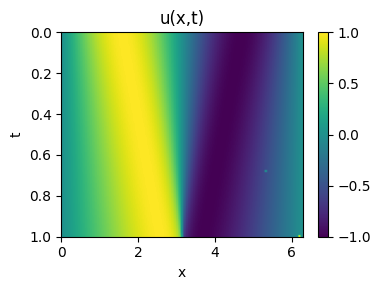

In [13]:
# 生成burgers数据集，真解：
# u(x, t) = sin(x_0)
# x = x_0 + sin(x_0) * t

# 定义隐式方程和其导数
def f(x, a, b):
    return x + np.sin(x) * b - a

def df(x, b):
    return 1 + b * np.cos(x)

# Newton-Raphson方法求解x0
def newton_method(a, b, x0, tol=1e-3, max_iter=1000):
    x = x0
    for i in range(max_iter):
        # 更新x
        x_new = x - f(x, a, b) / df(x, b)
        x = x_new
        # 每10次迭代打印一次信息
        if (i+1) % 800 == 0:
            print(f"Iteration {i}: x = {x_new}, loss = {np.abs(f(x_new, a, b)).max()}")
            print(a, b)

        # 判断是否收敛
        if np.abs(f(x, a, b)) < tol:
            return x
    return x  # 返回最终迭代结果

# 定义函数求解 Burgers 方程的解析解
def get_burgers(x, t):

    xi = np.zeros(x.shape)
    for i in range(x.shape[0]):
        xi[i] = newton_method(x[i], t[i], 1)

    return np.sin(xi)

# 获取测试数据
test, _, _, _, _ = get_data([0, 2*np.pi], [0, 1], 101, 101)  # (10201, 2)

x = test[:, 0]  # (10201, 1)
t = test[:, 1]

# 计算解析解
u = get_burgers(x, t).reshape(101, 101)


plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

# 定义保存的字典，键名为 'u'
data_dict = {'u': u}

# 使用 scipy.io.savemat 保存为 .mat 文件
scipy.io.savemat('burgers.mat', data_dict)

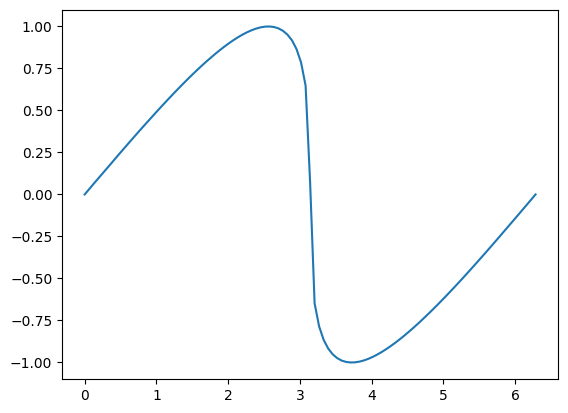

In [11]:
u_1 = u[99, :]
x = np.linspace(0, 2*np.pi, 101)
plt.plot(x, u_1)
plt.show()

In [3]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [4]:
# 几何区域：0<=x<=2*pi, 0<=t<=1
# 离散化：101*101网格
# res: 所有散点坐标
# b_left, b_right, b_upper, b_lower：边界点坐标

res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 101, 101)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

# 分别提取散点的x t坐标 --> 列表
x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

print('res shape: ', res.shape, 'b_left shape: ', b_left.shape, 'b_right shape: ', b_right.shape, 'b_upper shape: ', b_upper.shape, 'b_lower shape: ', b_lower.shape)

res shape:  torch.Size([10201, 2]) b_left shape:  torch.Size([101, 2]) b_right shape:  torch.Size([101, 2]) b_upper shape:  torch.Size([101, 2]) b_lower shape:  torch.Size([101, 2])


In [5]:
# Train PINNs -- MLP
model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))  # 总的参数量

/tmp/ipykernel_235700/4129593387.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


In [11]:
loss_track = []

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)  # (n, 1)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u = pred_res
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]  # (n, 1)
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + u * u_x) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)  # 周期性边界：u(x=L, t) = u(x=R, t)
        loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0])) ** 2)  # 初值：u(x=0, t) = sin(x)
        # print('loss: ', loss_res, loss_bc, loss_ic)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


In [7]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.053993, Loss_BC: 0.000441, Loss_IC: 0.035853
Train Loss: 0.090287


relative L1 error: 0.358798
relative L2 error: 0.419797


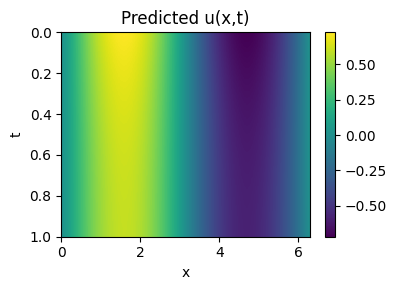

In [8]:
# Visualize PINNs 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

mat = scipy.io.loadmat('./burgers.mat')
u = mat['u'].reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_pinns_pred.png')
plt.show()

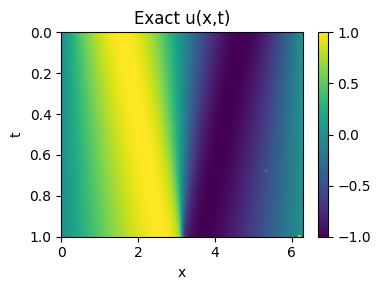

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_exact.png')
plt.show()

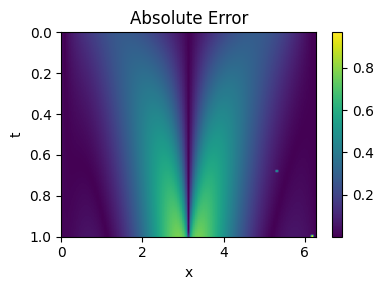

In [10]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_pinns_error.png')
plt.show()